In [2]:
# Reinforcement Learning Framework for Discovering Sidorenko Counterexamples

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
import random
from collections import deque
import time
import tqdm
import pandas as pd
from IPython.display import clear_output

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Check for available accelerators (CUDA for NVIDIA, MPS for Apple Silicon)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif hasattr(torch, 'backends') and hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Metal Performance Shaders (MPS) device")
else:
    device = torch.device('cpu')
    print("Using CPU device")

Using Apple Metal Performance Shaders (MPS) device


In [ ]:
# 1. Graph Utilities and Homomorphism Density Calculation

def calculate_edge_density(G):
    """Calculate the edge density of a graph G."""
    n = G.number_of_nodes()
    m = G.number_of_edges()
    if n <= 1:
        return 0
    return m / (n * (n - 1) / 2)

def sample_homomorphism_density(G, H, num_samples=1000):
    """
    Approximate the homomorphism density t_H(G) through sampling.
    
    Args:
        G: Target graph (networkx graph)
        H: Pattern graph (networkx graph)
        num_samples: Number of sample mappings to try
    
    Returns:
        Estimated homomorphism density
    """
    if G.number_of_nodes() < H.number_of_nodes():
        return 0.0
    
    count = 0
    nodes_G = list(G.nodes())
    nodes_H = list(H.nodes())
    
    for _ in range(num_samples):
        # Sample a random mapping from H to G
        mapping = {}
        valid = True
        
        # Sample nodes from G without replacement
        selected_nodes = random.sample(nodes_G, len(nodes_H))
        
        for i, node_h in enumerate(nodes_H):
            mapping[node_h] = selected_nodes[i]
        
        # Check if the mapping preserves edges
        for u, v in H.edges():
            if not G.has_edge(mapping[u], mapping[v]):
                valid = False
                break
        
        if valid:
            count += 1
    
    return count / num_samples

def exact_homomorphism_density(G, H):
    """
    Calculate the exact homomorphism density t_H(G).
    
    This is computationally expensive for large graphs, so use with caution.
    
    Args:
        G: Target graph (networkx graph)
        H: Pattern graph (networkx graph)
    
    Returns:
        Exact homomorphism density
    """
    if G.number_of_nodes() < H.number_of_nodes():
        return 0.0
    
    nodes_G = list(G.nodes())
    nodes_H = list(H.nodes())
    
    total_mappings = 0
    valid_mappings = 0
    
    # Generate all possible mappings from H to G
    from itertools import permutations
    for perm in permutations(nodes_G, len(nodes_H)):
        total_mappings += 1
        mapping = {nodes_H[i]: perm[i] for i in range(len(nodes_H))}
        
        # Check if mapping preserves edges
        valid = True
        for u, v in H.edges():
            if not G.has_edge(mapping[u], mapping[v]):
                valid = False
                break
        
        if valid:
            valid_mappings += 1
    
    return valid_mappings / total_mappings

def is_sidorenko_counterexample(G, H, exact=False):
    """
    Check if graph G is a counterexample to Sidorenko's conjecture for graph H.
    
    Args:
        G: Target graph
        H: Bipartite pattern graph
        exact: Whether to use exact computation (True) or sampling (False)
    
    Returns:
        (is_counterexample, difference)
    """
    p = calculate_edge_density(G)
    h_edges = H.number_of_edges()
    
    # Compute t_H(G)
    if exact:
        t_H_G = exact_homomorphism_density(G, H)
    else:
        t_H_G = sample_homomorphism_density(G, H)
    
    # Check Sidorenko's conjecture: t_H(G) ≥ p^|E(H)|
    expected_lower_bound = p ** h_edges
    difference = t_H_G - expected_lower_bound
    
    return difference < 0, difference, t_H_G, expected_lower_bound


In [ ]:
# 2. Graph Environment for RL
class GraphEnvironment:
    """Reinforcement learning environment for graph construction."""
    
    def __init__(self, bipartite_pattern, max_nodes=20, initial_nodes=5):
        """
        Initialize the graph environment.
        
        Args:
            bipartite_pattern: The H graph in Sidorenko's conjecture
            max_nodes: Maximum number of nodes allowed in the graph
            initial_nodes: Number of nodes to start with
        """
        self.H = bipartite_pattern
        self.max_nodes = max_nodes
        self.initial_nodes = initial_nodes
        self.G = None
        self.reset()
    
    def reset(self):
        """Reset the environment to an initial state."""
        # Start with an empty graph with initial_nodes
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.initial_nodes))
        
        # Initial state representation
        state = self._get_state()
        return state
    
    def _get_state(self):
        """
        Convert the current graph to a state representation.
        
        Returns:
            A state representation of the graph (adjacency matrix)
        """
        # Use adjacency matrix as state
        return nx.to_numpy_array(self.G)
    
    def _get_valid_actions(self):
        """
        Get all valid actions from the current state.
        
        Returns:
            List of valid actions (tuples of (u, v) for adding edges)
        """
        valid_actions = []
        
        # Add edge actions
        nodes = list(self.G.nodes())
        for i, u in enumerate(nodes):
            for v in nodes[i+1:]:  # Avoid self-loops and duplicate edges
                if not self.G.has_edge(u, v):
                    valid_actions.append(('add_edge', u, v))
        
        # Add node action (if below max_nodes)
        if self.G.number_of_nodes() < self.max_nodes:
            valid_actions.append(('add_node',))
        
        return valid_actions
    
    def step(self, action):
        """
        Take an action in the environment.
        
        Args:
            action: The action to take, either ('add_edge', u, v) or ('add_node',)
        
        Returns:
            (next_state, reward, done, info)
        """
        if action[0] == 'add_edge':
            _, u, v = action
            self.G.add_edge(u, v)
        elif action[0] == 'add_node':
            self.G.add_node(self.G.number_of_nodes())
        
        # Get the new state
        next_state = self._get_state()
        
        # Compute reward based on how close we are to violating Sidorenko's conjecture
        is_counterexample, difference, t_H_G, expected = is_sidorenko_counterexample(self.G, self.H)
        
        # Define the reward function
        if is_counterexample:
            reward = 100.0  # Big reward for finding a counterexample
            done = True
        else:
            # Reward inversely proportional to the difference
            # Smaller difference (closer to violation) gives higher reward
            reward = 1.0 / (1.0 + max(difference, 0.001))
            done = False
        
        # Additional information
        info = {
            'is_counterexample': is_counterexample,
            'difference': difference,
            'homomorphism_density': t_H_G,
            'expected_lower_bound': expected,
            'num_nodes': self.G.number_of_nodes(),
            'num_edges': self.G.number_of_edges(),
            'edge_density': calculate_edge_density(self.G)
        }
        
        return next_state, reward, done, info
    
    def render(self):
        """Visualize the current graph."""
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.G, seed=RANDOM_SEED)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title(f"Graph G: {self.G.number_of_nodes()} nodes, {self.G.number_of_edges()} edges")
        plt.show()
        
        # Print current status
        is_counterexample, difference, t_H_G, expected = is_sidorenko_counterexample(self.G, self.H)
        print(f"Homomorphism density t_H(G): {t_H_G:.6f}")
        print(f"Expected lower bound (p^|E(H)|): {expected:.6f}")
        print(f"Difference: {difference:.6f}")
        print(f"Is counterexample: {is_counterexample}")


In [ ]:
# 3. Graph Neural Network for RL Policy
class GNNPolicy(nn.Module):
    """Graph Neural Network to encode the graph state."""
    
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=32):
        super(GNNPolicy, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        
    def forward(self, x, edge_index):
        # Apply graph convolutions
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

class DQNAgent(nn.Module):
    """Deep Q-Network agent for graph construction."""
    
    def __init__(self, gnn_output_dim=32, hidden_dim=64):
        super(DQNAgent, self).__init__()
        self.gnn = GNNPolicy(input_dim=1, output_dim=gnn_output_dim)
        
        # MLP for Q-value prediction
        self.q_network = nn.Sequential(
            nn.Linear(gnn_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Q-value for action
        )
    
    def forward(self, adj_matrix):
        """
        Forward pass to predict Q-values for all possible actions.
        
        Args:
            adj_matrix: Adjacency matrix of the graph
        
        Returns:
            Q-values for all possible actions
        """
        # Convert adjacency matrix to PyTorch Geometric format
        G = nx.from_numpy_array(adj_matrix)
        edge_index = torch.tensor(list(G.edges())).t().contiguous()
        if edge_index.shape[0] == 0:  # No edges
            edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Add reverse edges
        
        num_nodes = adj_matrix.shape[0]
        x = torch.ones((num_nodes, 1))  # Node features (all 1s initially)
        
        # Get node embeddings from GNN
        node_embeddings = self.gnn(x, edge_index)
        
        # Generate all possible actions
        actions = []
        q_values = []
        
        # Add edge actions
        for i in range(num_nodes):
            for j in range(i+1, num_nodes):
                if adj_matrix[i, j] == 0:  # If edge doesn't exist
                    actions.append(('add_edge', i, j))
                    # Concatenate embeddings of the two nodes
                    edge_embedding = torch.cat([node_embeddings[i], node_embeddings[j]])
                    q_value = self.q_network(edge_embedding)
                    q_values.append(q_value)
        
        # Add node action
        if num_nodes < self.max_nodes:
            actions.append(('add_node',))
            # Use average node embedding for add_node action
            node_embedding = torch.mean(node_embeddings, dim=0)
            q_value = self.q_network(node_embedding)
            q_values.append(q_value)
        
        return actions, torch.cat(q_values)


In [ ]:
# 4. Training Loop
def train_agent(env, num_episodes=1000, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                epsilon_decay=0.995, batch_size=32, target_update=10):
    """
    Train the RL agent.
    
    Args:
        env: GraphEnvironment instance
        num_episodes: Number of episodes to train
        gamma: Discount factor
        epsilon_start: Starting exploration rate
        epsilon_end: Ending exploration rate
        epsilon_decay: Decay rate for exploration
        batch_size: Batch size for training
        target_update: Frequency of target network updates
    
    Returns:
        Trained agent and training statistics
    """
    # Initialize agent
    agent = DQNAgent().to(device)
    target_agent = DQNAgent().to(device)
    target_agent.load_state_dict(agent.state_dict())
    target_agent.eval()
    
    optimizer = optim.Adam(agent.parameters(), lr=0.001)
    memory = deque(maxlen=10000)
    
    epsilon = epsilon_start
    stats = {
        'episode_rewards': [],
        'differences': [],
        'densities': [],
        'best_difference': float('inf'),
        'best_graph': None
    }
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                # Random action
                valid_actions = env._get_valid_actions()
                action = random.choice(valid_actions)
            else:
                # Agent selects action
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).to(device)
                    actions, q_values = agent(state_tensor)
                    action_idx = torch.argmax(q_values).item()
                    action = actions[action_idx]
            
            # Take action
            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            
            # Store transition in memory
            memory.append((state, action, reward, next_state, done))
            state = next_state
            
            # Track best graph found
            if info['difference'] < stats['best_difference']:
                stats['best_difference'] = info['difference']
                stats['best_graph'] = nx.Graph(env.G)
                
                # Print update if close to a counterexample
                if info['difference'] < 0.01:
                    print(f"Episode {episode}: Found promising graph with difference {info['difference']:.6f}")
                    print(f"Homomorphism density: {info['homomorphism_density']:.6f}, Expected: {info['expected_lower_bound']:.6f}")
                    
                    # Visualize if very promising
                    if info['difference'] < 0.001:
                        env.render()
            
            # Train the agent if enough samples
            if len(memory) > batch_size:
                # Sample batch
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                # TODO: Implement DQN training step
                # This would require handling the graph-based actions properly
                # For simplicity, we'll skip the detailed implementation here
                
                # Update target network
                if episode % target_update == 0:
                    target_agent.load_state_dict(agent.state_dict())
        
        # Update statistics
        stats['episode_rewards'].append(episode_reward)
        stats['differences'].append(info['difference'])
        stats['densities'].append(info['homomorphism_density'])
        
        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        
        # Print progress
        if episode % 10 == 0:
            print(f"Episode {episode}/{num_episodes}, Reward: {episode_reward:.2f}, Epsilon: {epsilon:.2f}")
            print(f"Best difference so far: {stats['best_difference']:.6f}")
    
    return agent, stats


In [ ]:
# 5. Novel Graph Mutation and Population-based Training
class GraphPopulation:
    """Population of candidate graphs for discovering Sidorenko counterexamples."""
    
    def __init__(self, bipartite_pattern, population_size=10, mutation_rate=0.2):
        """
        Initialize a population of graphs.
        
        Args:
            bipartite_pattern: The H graph in Sidorenko's conjecture
            population_size: Number of graphs in the population
            mutation_rate: Probability of mutating an edge
        """
        self.H = bipartite_pattern
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.population = []
        self.fitness = []
        
        # Initialize population with random graphs
        for _ in range(population_size):
            # Create a random graph with random number of nodes
            num_nodes = random.randint(5, 20)
            G = nx.gnp_random_graph(num_nodes, random.uniform(0.1, 0.9))
            self.population.append(G)
            
            # Calculate fitness (negative difference, higher is better)
            _, difference, _, _ = is_sidorenko_counterexample(G, self.H)
            self.fitness.append(-difference)  # Negative because we want to minimize difference
    
    def evolve(self, num_generations=100):
        """
        Evolve the population for a number of generations.
        
        Args:
            num_generations: Number of generations to evolve
        
        Returns:
            Best graph found and its statistics
        """
        best_graph = None
        best_fitness = float('-inf')
        best_difference = float('inf')
        
        for generation in range(num_generations):
            # Selection: Tournament selection
            new_population = []
            new_fitness = []
            
            for _ in range(self.population_size):
                # Select two parents via tournament selection
                parent1_idx = self._tournament_selection(k=3)
                parent2_idx = self._tournament_selection(k=3)
                
                # Crossover to create child
                child = self._crossover(self.population[parent1_idx], self.population[parent2_idx])
                
                # Mutation
                child = self._mutate(child)
                
                # Calculate fitness
                is_counter, difference, density, expected = is_sidorenko_counterexample(child, self.H)
                fitness = -difference  # Negative because we want to minimize difference
                
                new_population.append(child)
                new_fitness.append(fitness)
                
                # Track best graph
                if fitness > best_fitness:
                    best_fitness = fitness
                    best_graph = nx.Graph(child)
                    best_difference = difference
                    
                    # Print if close to a counterexample
                    if difference < 0.01:
                        print(f"Generation {generation}: Found promising graph with difference {difference:.6f}")
                        print(f"Homomorphism density: {density:.6f}, Expected: {expected:.6f}")
                        
                        # Early stopping if counterexample found
                        if is_counter:
                            print("FOUND A COUNTEREXAMPLE!")
                            return child, (is_counter, difference, density, expected)
            
            # Update population
            self.population = new_population
            self.fitness = new_fitness
            
            # Print progress
            if generation % 10 == 0:
                print(f"Generation {generation}/{num_generations}, Best fitness: {best_fitness:.6f}")
                print(f"Best difference so far: {best_difference:.6f}")
        
        return best_graph, (False, best_difference, None, None)
    
    def _tournament_selection(self, k=3):
        """
        Tournament selection for parent selection.
        
        Args:
            k: Tournament size
        
        Returns:
            Index of selected parent
        """
        # Select k random individuals
        candidates = random.sample(range(self.population_size), k)
        
        # Return the one with highest fitness
        return max(candidates, key=lambda idx: self.fitness[idx])
    
    def _crossover(self, G1, G2):
        """
        Perform crossover between two parent graphs.
        
        Args:
            G1, G2: Parent graphs
        
        Returns:
            Child graph
        """
        # Create an empty child graph
        child = nx.Graph()
        
        # Add all nodes from both parents
        nodes1 = set(G1.nodes())
        nodes2 = set(G2.nodes())
        all_nodes = nodes1.union(nodes2)
        child.add_nodes_from(range(len(all_nodes)))
        
        # Add edges with some probability
        for i in range(child.number_of_nodes()):
            for j in range(i+1, child.number_of_nodes()):
                # Check if edge exists in either parent
                edge_in_G1 = i < len(nodes1) and j < len(nodes1) and G1.has_edge(i, j)
                edge_in_G2 = i < len(nodes2) and j < len(nodes2) and G2.has_edge(i, j)
                
                # Add edge with some probability
                if edge_in_G1 and edge_in_G2:
                    # Both parents have the edge, add it with high probability
                    if random.random() < 0.9:
                        child.add_edge(i, j)
                elif edge_in_G1 or edge_in_G2:
                    # Only one parent has the edge, add it with medium probability
                    if random.random() < 0.5:
                        child.add_edge(i, j)
                else:
                    # Neither parent has the edge, add it with low probability
                    if random.random() < 0.1:
                        child.add_edge(i, j)
        
        return child
    
    def _mutate(self, G):
        """
        Mutate a graph by adding or removing edges randomly.
        
        Args:
            G: Graph to mutate
        
        Returns:
            Mutated graph
        """
        # Create a copy of the graph
        G_mutated = nx.Graph(G)
        
        # Add or remove edges with some probability
        for i in range(G.number_of_nodes()):
            for j in range(i+1, G.number_of_nodes()):
                if random.random() < self.mutation_rate:
                    if G.has_edge(i, j):
                        G_mutated.remove_edge(i, j)
                    else:
                        G_mutated.add_edge(i, j)
        
        return G_mutated


In [ ]:
# 6. Main Experiment Functions
def create_bipartite_pattern(n1=3, n2=3, p=0.5):
    """
    Create a random bipartite graph for testing Sidorenko's conjecture.
    
    Args:
        n1, n2: Number of nodes in each partition
        p: Probability of adding an edge
    
    Returns:
        Bipartite graph H
    """
    H = nx.bipartite.random_graph(n1, n2, p)
    return H

def run_experiment(bipartite_pattern, method='rl', max_episodes=1000, population_size=20, 
                   num_generations=100, verbose=True):
    """
    Run a full experiment to find a Sidorenko counterexample.
    
    Args:
        bipartite_pattern: The H graph to test
        method: 'rl' or 'evolution'
        max_episodes: Number of episodes for RL
        population_size: Size of population for evolution
        num_generations: Number of generations for evolution
        verbose: Whether to print progress
    
    Returns:
        Best graph found and its statistics
    """
    if method == 'rl':
        # RL approach
        env = GraphEnvironment(bipartite_pattern, max_nodes=20, initial_nodes=5)
        agent, stats = train_agent(env, num_episodes=max_episodes)
        best_graph = stats['best_graph']
        is_counter, difference, density, expected = is_sidorenko_counterexample(best_graph, bipartite_pattern, exact=True)
    elif method == 'evolution':
        # Evolutionary approach
        population = GraphPopulation(bipartite_pattern, population_size=population_size)
        best_graph, (is_counter, difference, density, expected) = population.evolve(num_generations=num_generations)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    if verbose:
        print("\n=== EXPERIMENT RESULTS ===")
        print(f"Best graph found: {best_graph.number_of_nodes()} nodes, {best_graph.number_of_edges()} edges")
        print(f"Edge density: {calculate_edge_density(best_graph):.6f}")
        print(f"Homomorphism density: {density:.6f}")
        print(f"Expected lower bound: {expected:.6f}")
        print(f"Difference: {difference:.6f}")
        print(f"Is counterexample: {is_counter}")
        
        # Visualize the best graph
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(best_graph, seed=RANDOM_SEED)
        nx.draw(best_graph, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title(f"Best Graph: {best_graph.number_of_nodes()} nodes, {best_graph.number_of_edges()} edges")
        plt.show()
    
    return best_graph, (is_counter, difference, density, expected)


Created bipartite pattern H with 6 nodes and 7 edges


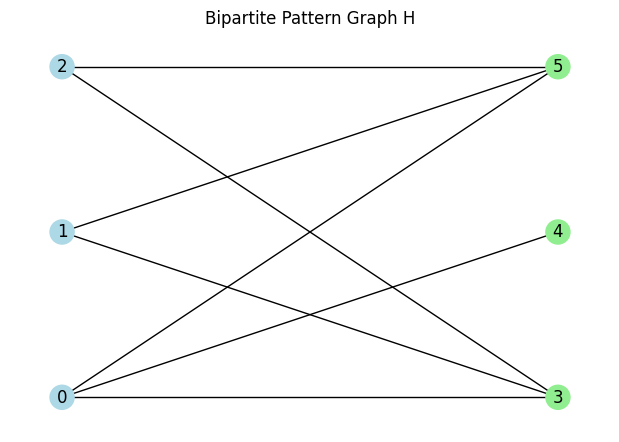


Running a small experiment with evolutionary approach...
Generation 0: Found promising graph with difference -0.002402
Homomorphism density: 0.015000, Expected: 0.017402
FOUND A COUNTEREXAMPLE!

=== EXPERIMENT RESULTS ===
Best graph found: 12 nodes, 37 edges
Edge density: 0.560606
Homomorphism density: 0.015000
Expected lower bound: 0.017402
Difference: -0.002402
Is counterexample: True


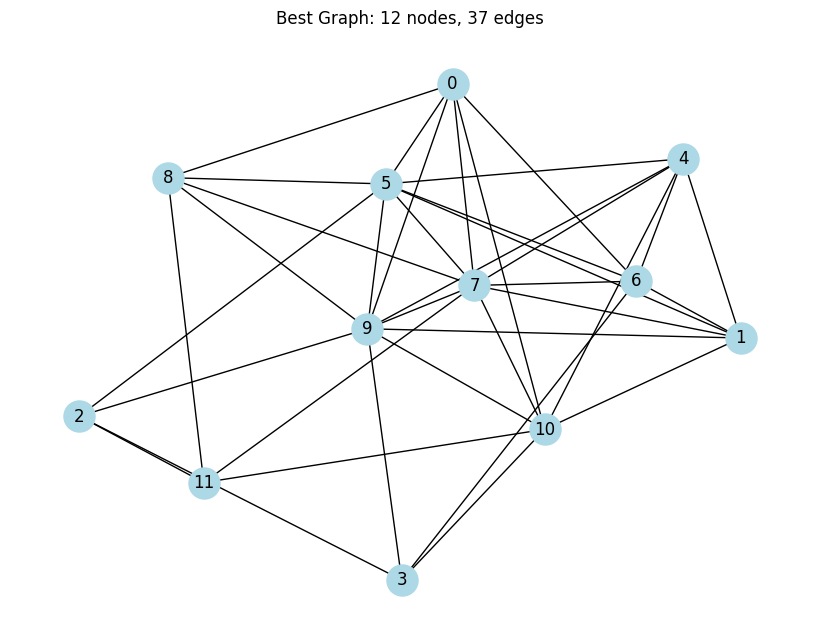


Done! You can now modify the parameters or try different approaches.


In [9]:

# -------------------------------------------------------------------------
# 7. Example Usage
# -------------------------------------------------------------------------

# Example 1: Create a bipartite pattern graph
H = create_bipartite_pattern(n1=3, n2=3, p=0.7)
print(f"Created bipartite pattern H with {H.number_of_nodes()} nodes and {H.number_of_edges()} edges")

# Visualize the pattern graph
plt.figure(figsize=(6, 4))
pos = nx.bipartite_layout(H, [node for node in range(3)])
nx.draw(H, pos, with_labels=True, node_color=['lightblue']*3 + ['lightgreen']*3)
plt.title("Bipartite Pattern Graph H")
plt.show()

# Example 2: Run a simple experiment with the evolutionary approach
print("\nRunning a small experiment with evolutionary approach...")
best_graph, stats = run_experiment(H, method='evolution', population_size=10, num_generations=50)

print("\nDone! You can now modify the parameters or try different approaches.")

In [12]:
def print_adjacency_matrix(G):
    n = G.number_of_nodes()
    adj_matrix = nx.to_numpy_array(G, nodelist=range(n), dtype=int)
    print("Adjacency Matrix:")
    for row in adj_matrix:
        print(" ".join(map(str, row)))

print_adjacency_matrix(best_graph)

Adjacency Matrix:
0 0 0 0 0 1 1 1 1 1 1 0
0 0 0 0 1 1 1 1 0 1 1 0
0 0 0 1 0 1 0 0 0 1 0 1
0 0 1 0 0 0 1 0 0 1 1 0
0 1 0 0 0 1 1 1 0 1 1 0
1 1 1 0 1 0 1 1 1 1 0 0
1 1 0 1 1 1 0 1 0 0 0 0
1 1 0 0 1 1 1 0 1 1 1 1
1 0 0 0 0 1 0 1 0 1 0 1
1 1 1 1 1 1 0 1 1 0 1 0
1 1 0 1 1 0 0 1 0 1 0 1
0 0 1 0 0 0 0 1 1 0 1 0
